In [31]:
# Installation des packages nécessaires
!pip install pycaret yfinance pandas numpy
!pip install catboost
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost
!pip install mlxtend
!pip install statsmodels
!pip install tensorflow
!pip install scipy

In [ ]:
# Import des bibliothèques
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [ ]:
# Téléchargement des données Accor sur les 3 dernières années
start_date = datetime.now() - timedelta(days=3*365)
df = yf.download('AC.PA', start=start_date)

# Affichage des premières lignes et informations sur le dataset
print("\nAperçu des données :")
print(df.head())

print("\nInformations sur le dataset :")
print(df.info())

print("\nStatistiques descriptives :")
print(df.describe())

# Vérification des valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())


Testing with 12 months of data starting from 2023-11-21...


[*********************100%***********************]  1 of 1 completed


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 159, number of used features: 17
[LightGBM] [Info] Start training from score 0.002012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.0076,0.0001,0.0095,0.0680,0.0083,1.4132,0.0800
huber,Huber Regressor,0.0079,0.0001,0.0098,0.0193,0.0084,1.4009,0.1080
br,Bayesian Ridge,0.0081,0.0001,0.0100,0.0065,0.0086,1.5161,0.0840
ridge,Ridge Regression,0.0083,0.0001,0.0102,-0.0369,0.0086,1.6769,0.2700
llar,Lasso Least Angle Regression,0.0081,0.0001,0.0104,-0.0378,0.0091,0.9797,0.0800
dummy,Dummy Regressor,0.0081,0.0001,0.0104,-0.0378,0.0091,0.9797,0.0700
en,Elastic Net,0.0081,0.0001,0.0104,-0.0378,0.0091,0.9797,0.0720
lasso,Lasso Regression,0.0081,0.0001,0.0104,-0.0378,0.0091,0.9797,0.2820
par,Passive Aggressive Regressor,0.0080,0.0001,0.0104,-0.0404,0.0103,0.8000,0.0860
lar,Least Angle Regression,0.0083,0.0001,0.0102,-0.0406,0.0086,1.6862,0.0700


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.0096,0.0002,0.0126,0.1965,0.0109,1.6430


KeyError: 'Label'

In [34]:
# Import des bibliothèques supplémentaires
from pycaret.regression import *
import warnings
warnings.filterwarnings('ignore')

In [35]:
def add_technical_indicators(df):
    data = df.copy()
    data.columns = [col[0] for col in data.columns]
    
    # Moyennes mobiles
    data['SMA5'] = data['Close'].rolling(window=5).mean()
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    
    # RSI modifié pour éviter les divisions par zéro
    def calculate_rsi(data, periods=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        # Éviter la division par zéro
        loss = loss.replace(0, np.nan)
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    data['RSI'] = calculate_rsi(data['Close'])
    
    # MACD
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    bb_middle = data['Close'].rolling(window=20).mean()
    bb_std = data['Close'].rolling(window=20).std()
    data['BB_middle'] = bb_middle
    data['BB_upper'] = bb_middle + 2*bb_std
    data['BB_lower'] = bb_middle - 2*bb_std
    
    # Momentum
    data['Momentum'] = data['Close'] - data['Close'].shift(4)


    # Nouveaux indicateurs
    # Stochastique %K
    data['Stoch_K'] = ((data['Close'] - data['Low'].rolling(14).min()) / 
                       (data['High'].rolling(14).max() - data['Low'].rolling(14).min())) * 100
    
    # Average True Range (ATR)
    data['ATR'] = data['High'].sub(data['Low'])
    
    # On Balance Volume (OBV)
    data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).cumsum()
    
    # Price Rate of Change
    data['ROC'] = data['Close'].pct_change(periods=12)
    
    # Ajout de fenêtres temporelles différentes pour les moyennes mobiles
    data['SMA10'] = data['Close'].rolling(window=10).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    
    return data

In [36]:
def prepare_data(df):
    data = add_technical_indicators(df)
    
    # Ajout de features temporelles
    data['Day_of_Week'] = pd.to_datetime(data.index).dayofweek
    data['Month'] = pd.to_datetime(data.index).month
    
    # Calcul des variations sur plusieurs périodes
    for col in ['Close', 'Volume']:
        data[f'{col}_pct_1d'] = data[col].pct_change(1)
        data[f'{col}_pct_5d'] = data[col].pct_change(5)
        data[f'{col}_pct_20d'] = data[col].pct_change(20)
    
    # Créer des features de volatilité
    data['Volatility'] = data['Close'].rolling(window=20).std()
    
    # Target variable avec plusieurs horizons
    data['Target_1d'] = data['Close'].pct_change().shift(-1)
    data['Target_5d'] = data['Close'].pct_change(periods=5).shift(-5)
    
    # Nettoyage
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    
    return data

# Import supplémentaire nécessaire
import numpy as np

# Préparation des données
data = prepare_data(df)

# Vérification des données
print("Vérification des valeurs infinies :")
print(np.isinf(data).sum().sum())
print("\nVérification des NaN :")
print(data.isna().sum().sum())

Vérification des valeurs infinies :
0

Vérification des NaN :
0


In [37]:
# Configuration de PyCaret avec des paramètres corrigés
exp = setup(
    data=data,                          # Fournit le jeu de données principal pour l'analyse.
    target='Target_1d',                 # Définit la colonne cible à prédire, ici "Target_1d".
    train_size=0.8,                     # Spécifie que 80% des données seront utilisées pour l'entraînement.
    fold=5,                             # Configure une validation croisée à 5 plis pour évaluer les modèles.
    transformation=True,                # Active les transformations des données (comme la normalisation des valeurs).
    feature_selection=True,             # Active la sélection des caractéristiques pour ne garder que les plus importantes.
    feature_selection_method='classic', # Utilise une méthode classique pour la sélection des caractéristiques.
    remove_multicollinearity=True,      # Supprime les variables très corrélées entre elles.
    multicollinearity_threshold=0.9,    # Supprime une variable si son coefficient de corrélation est supérieur à 0.9.
    normalize=True,                     # Normalise les données pour les ramener dans une plage uniforme (utile pour les modèles sensibles aux échelles).
    session_id=123,                     # Fixe une graine aléatoire pour garantir la reproductibilité des résultats.
    verbose=False                       # Désactive les messages détaillés pour garder l'exécution silencieuse.
)
# Cette configuration établit un pipeline complet pour prétraiter les données et préparer l'environnement PyCaret.

# Comparaison des modèles individuels
print("\nComparaison des modèles individuels :")
best_models = compare_models(n_select=3)  # Compare tous les modèles disponibles et sélectionne les 3 meilleurs.
print(pull())                            # Affiche un tableau avec les performances des modèles testés.
# Cette étape identifie les modèles les plus performants selon les métriques choisies (par défaut, l'exactitude).

# Création d'un ensemble avec les modèles spécifiques
print("\nCréation de l'ensemble des meilleurs modèles :")
models_to_blend = [
    create_model('rf'),      # Crée un modèle Random Forest, robuste pour les données tabulaires.
    create_model('lightgbm'), # Crée un modèle LightGBM, efficace et rapide pour des données volumineuses.
    create_model('br'),      # Crée un modèle de régression bayésienne, utile pour les données avec incertitudes.
    create_model('en'),      # Crée un modèle Elastic Net, qui combine pénalités L1 et L2 pour gérer la régularisation.
    create_model('gbr'),    # Crée un modèle Gradient Boosting, performant pour capturer des relations non linéaires.
    create_model('et'),        # Extra Trees
    create_model('catboost'),  # CatBoost
    create_model('xgboost'),   # XGBoost
    create_model('knn'),       # K-Nearest Neighbors
    create_model('svm'),       # Support Vector Regressor
    create_model('dt'),        # Decision Tree
    create_model('huber'),     # Huber Regressor
    create_model('mlp')        # Neural Network      # Crée un modèle Gradient Boosting, performant pour capturer des relations non linéaires.
]
# Ces modèles sont choisis pour leur complémentarité et leur performance dans des scénarios variés.

blended = blend_models(estimator_list=models_to_blend)
# Combine les modèles de la liste `models_to_blend` pour créer un modèle d'ensemble ("blended model").
# Cette technique améliore souvent la robustesse et la généralisation en combinant les forces de chaque modèle.

print("\nPerformance du modèle ensemble :")
print(pull())  # Affiche les performances du modèle d'ensemble (ex : R², MAE, etc.).

# Finalement, on peut faire une prédiction de test
prediction = predict_model(blended)
# Applique le modèle d'ensemble "blended" sur un jeu de données de test pour effectuer des prédictions.
# Renvoie les résultats des prédictions, souvent accompagnés des probabilités (selon le type de tâche).

# Ce pipeline permet de comparer, sélectionner et améliorer les modèles en utilisant les fonctionnalités de PyCaret.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3022
[LightGBM] [Info] Number of data points in the train set: 574, number of used features: 18
[LightGBM] [Info] Start training from score 0.000078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.0122,0.0003,0.0172,0.1423,0.0144,1.6520,0.2260
huber,Huber Regressor,0.0123,0.0003,0.0174,0.1223,0.0148,1.5947,0.3100
br,Bayesian Ridge,0.0124,0.0003,0.0176,0.1047,0.0147,1.7111,0.2760
ridge,Ridge Regression,0.0125,0.0003,0.0176,0.1008,0.0145,1.7750,0.3700
lr,Linear Regression,0.0125,0.0003,0.0176,0.1006,0.0145,1.7778,0.9420
lar,Least Angle Regression,0.0125,0.0003,0.0176,0.1006,0.0145,1.7778,0.2500
lasso,Lasso Regression,0.0130,0.0004,0.0187,-0.0108,0.0180,1.0041,0.4140
dummy,Dummy Regressor,0.0130,0.0004,0.0187,-0.0108,0.0180,1.0041,0.2440
llar,Lasso Least Angle Regression,0.0130,0.0004,0.0187,-0.0108,0.0180,1.0041,0.2420
en,Elastic Net,0.0130,0.0004,0.0187,-0.0108,0.0180,1.0041,0.2380


                                    Model     MAE     MSE    RMSE      R2  \
omp           Orthogonal Matching Pursuit  0.0122  0.0003  0.0172  0.1423   
huber                     Huber Regressor  0.0123  0.0003  0.0174  0.1223   
br                         Bayesian Ridge  0.0124  0.0003  0.0176  0.1047   
ridge                    Ridge Regression  0.0125  0.0003  0.0176  0.1008   
lr                      Linear Regression  0.0125  0.0003  0.0176  0.1006   
lar                Least Angle Regression  0.0125  0.0003  0.0176  0.1006   
lasso                    Lasso Regression  0.0130  0.0004  0.0187 -0.0108   
dummy                     Dummy Regressor  0.0130  0.0004  0.0187 -0.0108   
llar         Lasso Least Angle Regression  0.0130  0.0004  0.0187 -0.0108   
en                            Elastic Net  0.0130  0.0004  0.0187 -0.0108   
par          Passive Aggressive Regressor  0.0132  0.0004  0.0186 -0.0114   
catboost               CatBoost Regressor  0.0137  0.0004  0.0189 -0.0225   

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0164,0.0006,0.0237,-0.0063,0.0191,1.6652
1,0.0128,0.0003,0.0180,-0.1099,0.0132,2.6102
2,0.0114,0.0003,0.0169,0.1247,0.0146,2.7339
3,0.0128,0.0004,0.0189,-0.0624,0.0142,1.9845
4,0.0124,0.0003,0.0169,-0.1389,0.0139,1.4911
Mean,0.0132,0.0004,0.0189,-0.0386,0.0150,2.0970
Std,0.0017,0.0001,0.0025,0.0932,0.0021,0.4970


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0173,0.0006,0.0245,-0.0764,0.0184,1.8056
1,0.0138,0.0003,0.0181,-0.1215,0.0141,3.3257
2,0.0125,0.0003,0.0181,-0.0047,0.0139,2.8100
3,0.0132,0.0004,0.0192,-0.1005,0.0140,1.8968
4,0.0126,0.0003,0.0162,-0.0416,0.0124,1.7842
Mean,0.0139,0.0004,0.0192,-0.0690,0.0146,2.3245
Std,0.0018,0.0001,0.0028,0.0417,0.0020,0.6296


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0154,0.0005,0.0218,0.1519,0.0189,1.4978
1,0.0124,0.0003,0.0166,0.0530,0.0137,2.4246
2,0.0112,0.0003,0.0168,0.1392,0.0137,1.9815
3,0.0124,0.0003,0.0178,0.0514,0.0148,1.5869
4,0.0107,0.0002,0.0148,0.1281,0.0122,1.0647
Mean,0.0124,0.0003,0.0176,0.1047,0.0147,1.7111
Std,0.0016,0.0001,0.0023,0.0436,0.0023,0.4606


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0166,0.0006,0.0239,-0.0200,0.0227,1.0161
1,0.0123,0.0003,0.0171,-0.0093,0.0165,0.9566
2,0.0121,0.0003,0.0183,-0.0225,0.0174,1.0469
3,0.0122,0.0003,0.0183,-0.0004,0.0178,0.9998
4,0.0119,0.0003,0.0159,-0.0016,0.0156,1.0011
Mean,0.0130,0.0004,0.0187,-0.0108,0.0180,1.0041
Std,0.0018,0.0001,0.0027,0.0091,0.0025,0.0292


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0169,0.0006,0.0241,-0.0334,0.0190,1.6576
1,0.0125,0.0003,0.0174,-0.0386,0.0138,2.7264
2,0.0116,0.0003,0.0171,0.1032,0.0145,2.2874
3,0.0127,0.0003,0.0186,-0.0341,0.0138,1.8038
4,0.0127,0.0004,0.0188,-0.4067,0.0154,1.4562
Mean,0.0133,0.0004,0.0192,-0.0819,0.0153,1.9863
Std,0.0019,0.0001,0.0025,0.1710,0.0020,0.4606


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0168,0.0006,0.0239,-0.0204,0.0196,1.8055
1,0.0127,0.0003,0.0171,-0.0050,0.0135,2.8589
2,0.0120,0.0003,0.0175,0.0692,0.0143,2.7717
3,0.0135,0.0004,0.0194,-0.1259,0.0146,2.0046
4,0.0126,0.0003,0.0185,-0.3547,0.0155,1.6256
Mean,0.0135,0.0004,0.0193,-0.0874,0.0155,2.2133
Std,0.0017,0.0001,0.0025,0.1475,0.0022,0.5067


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0179,0.0006,0.0250,-0.1176,0.0199,1.8713
1,0.0131,0.0003,0.0179,-0.0983,0.0136,3.0000
2,0.0120,0.0003,0.0170,0.1189,0.0147,3.1807
3,0.0135,0.0004,0.0192,-0.0995,0.0137,1.8915
4,0.0119,0.0002,0.0152,0.0840,0.0127,1.4332
Mean,0.0137,0.0004,0.0189,-0.0225,0.0149,2.2753
Std,0.0022,0.0001,0.0033,0.1021,0.0026,0.6877


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0176,0.0006,0.0244,-0.0664,0.0190,2.2479
1,0.0142,0.0004,0.0191,-0.2558,0.0140,3.3855
2,0.0126,0.0003,0.0181,-0.0034,0.0147,3.7099
3,0.0139,0.0004,0.0204,-0.2418,0.0143,2.1097
4,0.0131,0.0003,0.0169,-0.1282,0.0127,2.0208
Mean,0.0143,0.0004,0.0198,-0.1391,0.0149,2.6948
Std,0.0017,0.0001,0.0026,0.0980,0.0021,0.7076


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0161,0.0006,0.0238,-0.0093,0.0186,1.5656
1,0.0132,0.0003,0.0173,-0.0331,0.0129,3.3177
2,0.0131,0.0003,0.0179,0.0201,0.0150,2.5900
3,0.0133,0.0004,0.0197,-0.1610,0.0148,1.9065
4,0.0120,0.0002,0.0157,0.0178,0.0125,1.5231
Mean,0.0135,0.0004,0.0189,-0.0331,0.0148,2.1806
Std,0.0014,0.0001,0.0028,0.0668,0.0022,0.6850


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0405,0.0021,0.0463,-2.8326,0.0259,7.1057
1,0.0154,0.0004,0.0203,-0.4172,0.0119,3.8031
2,0.0154,0.0005,0.0217,-0.4303,0.0136,3.4174
3,0.0321,0.0013,0.0367,-3.0207,0.0236,7.8282
4,0.0133,0.0003,0.0172,-0.1770,0.0118,2.1687
Mean,0.0233,0.0009,0.0284,-1.3756,0.0174,4.8646
Std,0.0109,0.0007,0.0112,1.2711,0.0061,2.2043


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0210,0.0009,0.0302,-0.6293,0.0186,2.7023
1,0.0176,0.0007,0.0258,-1.2867,0.0194,3.0424
2,0.0172,0.0005,0.0230,-0.6199,0.0160,4.4178
3,0.0170,0.0006,0.0246,-0.8011,0.0155,2.7832
4,0.0173,0.0006,0.0246,-1.4075,0.0189,2.9880
Mean,0.0180,0.0007,0.0256,-0.9489,0.0177,3.1867
Std,0.0015,0.0001,0.0024,0.3337,0.0016,0.6282


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0151,0.0005,0.0214,0.1836,0.0188,1.4762
1,0.0122,0.0003,0.0164,0.0792,0.0137,2.2105
2,0.0113,0.0003,0.0167,0.1444,0.0139,1.7844
3,0.0122,0.0003,0.0177,0.0676,0.0149,1.4787
4,0.0108,0.0002,0.0147,0.1366,0.0127,1.0239
Mean,0.0123,0.0003,0.0174,0.1223,0.0148,1.5947
Std,0.0015,0.0001,0.0022,0.0431,0.0021,0.3920


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0410,0.0035,0.0592,-5.2582,0.0383,5.8560
1,0.0363,0.0021,0.0455,-6.1086,0.0360,12.6750
2,0.0348,0.0024,0.0490,-6.3191,0.0360,10.0741
3,0.0340,0.0020,0.0452,-5.1092,0.0319,6.0077
4,0.0356,0.0022,0.0467,-7.6455,0.0363,7.3596
Mean,0.0363,0.0024,0.0491,-6.0881,0.0357,8.3945
Std,0.0024,0.0005,0.0052,0.9084,0.0021,2.6213


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0173,0.0006,0.0250,-0.1161,0.0192,1.6610
1,0.0125,0.0003,0.0169,0.0204,0.0136,2.5265
2,0.0117,0.0003,0.0173,0.0838,0.0143,2.4059
3,0.0132,0.0004,0.0195,-0.1326,0.0145,1.6700
4,0.0121,0.0003,0.0159,-0.0060,0.0128,1.3303
Mean,0.0133,0.0004,0.0189,-0.0301,0.0149,1.9187
Std,0.0020,0.0001,0.0033,0.0825,0.0023,0.4650



Performance du modèle ensemble :
         MAE     MSE    RMSE      R2   RMSLE    MAPE
Fold                                                
0     0.0173  0.0006  0.0250 -0.1161  0.0192  1.6610
1     0.0125  0.0003  0.0169  0.0204  0.0136  2.5265
2     0.0117  0.0003  0.0173  0.0838  0.0143  2.4059
3     0.0132  0.0004  0.0195 -0.1326  0.0145  1.6700
4     0.0121  0.0003  0.0159 -0.0060  0.0128  1.3303
Mean  0.0133  0.0004  0.0189 -0.0301  0.0149  1.9187
Std   0.0020  0.0001  0.0033  0.0825  0.0023  0.4650


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0114,0.0002,0.0155,0.2062,0.0129,1.3316


Predictions

In [39]:
def analyze_trend(data, future_predictions):
    """
    Analyse la tendance et génère des recommandations
    """
    # Calcul du RSI
    def calculate_rsi(prices, periods=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    # Calcul de la volatilité
    def calculate_volatility(prices, window=10):
        return prices.pct_change().rolling(window=window).std() * np.sqrt(252) * 100

    # Calcul des tendances sur différentes périodes
    def determine_trend(prices, period):
        start_price = float(prices.iloc[-period])  # Conversion en float
        end_price = float(prices.iloc[-1])        # Conversion en float
        change = (end_price - start_price) / start_price * 100
        if change > 1:
            return "HAUSSIÈRE", change
        elif change < -1:
            return "BAISSIÈRE", change
        else:
            return "NEUTRE", change

    # Analyse des tendances
    rsi = float(calculate_rsi(data['Close']).iloc[-1])
    volatility = float(calculate_volatility(data['Close']).iloc[-1])

    trend_5d, var_5d = determine_trend(data['Close'], 5)
    trend_20d, var_20d = determine_trend(data['Close'], 20)

    def get_signal(rsi, trend, future_trend):
        """
        Détermine le signal en fonction du RSI, de la tendance actuelle et de la tendance future prédite
        """
        # Calculer la variation future prédite
        future_change = (future_trend[-1] - future_trend[0]) / future_trend[0] * 100
        
        if future_change > 0:  # Si la prédiction est haussière
            if rsi < 30:
                return "FORT SIGNAL D'ACHAT"
            elif rsi < 40:
                return "SIGNAL D'ACHAT"
            elif rsi > 80:  # On augmente le seuil de survente
                return "SIGNAL DE VENTE"
            else:
                return "TENDANCE HAUSSIÈRE - CONSERVER"
        else:  # Si la prédiction est baissière
            if rsi > 70:
                return "FORT SIGNAL DE VENTE"
            elif rsi > 60:
                return "SIGNAL DE VENTE"
            elif rsi < 20:
                return "SIGNAL D'ACHAT"
            else:
                return "TENDANCE BAISSIÈRE - ATTENDRE"

    # Détermination des signaux avec la tendance future
    signal_5d = get_signal(rsi, trend_5d, future_predictions)
    signal_20d = get_signal(rsi, trend_20d, future_predictions)

    # Affichage des résultats
    print("\nANALYSE DE LA TENDANCE")
    print("=" * 60)
    print(f"\nTendance à 5 jours:")
    print(f"Signal: {signal_5d}")
    print(f"Niveau de confiance: ÉLEVÉE")
    print(f"Variation attendue: {var_5d:.2f}%")
    print(f"Tendance court terme: {trend_5d}")
    print(f"Tendance moyen terme: {trend_5d}")

    print(f"\nTendance à 20 jours:")
    print(f"Signal: {signal_20d}")
    print(f"Niveau de confiance: ÉLEVÉE")
    print(f"Variation attendue: {var_20d:.2f}%")
    print(f"Tendance court terme: {trend_20d}")
    print(f"Tendance moyen terme: {trend_20d}")

    print("\nINDICATEURS TECHNIQUES")
    print("=" * 60)
    print(f"RSI (14 jours): {rsi:.2f}")
    print(f"Volatilité (10 jours): {volatility:.2f}")

    print("\nRECOMMANDATION FINALE")
    print("=" * 60)
    
    # Détermination de la recommandation finale
    if signal_5d != signal_20d:
        recommendation = "NEUTRE/ATTENTE"
        reasons = [
            "Signaux mixtes ou peu clairs",
            f"RSI: {rsi:.2f}",
            "Attendre une confirmation de tendance plus claire"
        ]
    else:
        if "FORT" in signal_5d:
            recommendation = signal_5d
            reasons = [
                f"RSI: {rsi:.2f}",
                f"Tendance {trend_5d} confirmée",
                "Momentum fort"
            ]
        else:
            recommendation = "NEUTRE/ATTENTE"
            reasons = [
                "Signaux pas assez marqués",
                f"RSI: {rsi:.2f}",
                "Attendre une meilleure configuration"
            ]

    print(f"RECOMMANDATION PRINCIPALE: {recommendation}")
    for reason in reasons:
        print(f"• {reason}")

In [48]:
from pycaret.regression import pull

def print_model_summary(rmse, r2, mape):
    print("\nRÉSUMÉ DE L'AUTOML")
    print("=" * 60)
    
    # Récupération des résultats de tous les modèles
    models_comparison = pull()
    
    # Obtenir le nombre réel de modèles disponibles
    n_models = len(models_comparison)
    n_to_show = min(5, n_models)  # Affiche jusqu'à 5 modèles ou moins si moins disponibles
    
    """BrokenPipeError
    print("\n1. MODÈLES TESTÉS (Top {n_to_show})")
    print("-" * 30)
    for i in range(n_to_show):
        model_row = models_comparison.iloc[i]
        print(f"• {model_row['Model']}")
        print(f"  - RMSE: {model_row['RMSE']:.4f}")
        print(f"  - R²: {model_row['R2']:.4f}")
        print(f"  - MAE: {model_row['MAE']:.4f}")"""
    
    print("\n2. PRÉTRAITEMENT APPLIQUÉ")
    print("-" * 30)
    print("• Scaling: Normalisation des données")
    print("• Feature Selection: Méthode classique")
    print("• Gestion Multicolinéarité: Seuil de 0.95")
    
    print("\n3. VALIDATION")
    print("-" * 30)
    print("• Métrique principale: RMSE")
    print("• Cross-validation: 5 folds")
    print("• Train/Test split: 80/20")
    
    print("\n4. MODÈLE FINAL (ENSEMBLE)")
    print("-" * 30)
    print("• Type: Voting Regressor")
    print("• Modèles composant l'ensemble:")
    for i, (model_name, model) in enumerate(blended.named_estimators_.items(), 1):
        base_name = str(model.__class__.__name__)
        print(f"  - {base_name}")
    
    # Si disponible, afficher les poids du modèle ensemble
    if hasattr(blended, 'weights_'):
        print("\n• Poids des modèles:")
        for name, weight in zip(blended.named_estimators_.keys(), blended.weights_):
            print(f"  - {name}: {weight:.3f}")
    
    print("\n5. PERFORMANCES FINALES")
    print("-" * 30)
    print(f"• RMSE: {rmse:.4f} €")
    print(f"• R²: {r2:.4f}")
    print(f"• MAPE: {mape:.2f}%")

In [41]:
def market_analysis_report(rsi, volatility, trend_5d, trend_20d, var_5d, var_20d):
    print("=" * 80)
    print(" " * 30 + "ANALYSE DE MARCHÉ")
    print("=" * 80 + "\n")

    # Tendance Court Terme
    print("📊 TENDANCE COURT TERME (5 JOURS)")
    print(f"Signal          : {trend_5d['signal']}")
    print(f"Confiance       : ÉLEVÉE")
    print(f"Variation       : {'🔴' if var_5d < 0 else '🟢'} {var_5d:.2f}%")
    print(f"Tendance        : ↘ {trend_5d['trend']}\n")

    # Tendance Long Terme
    print("📈 TENDANCE LONG TERME (20 JOURS)")
    print(f"Signal          : {trend_20d['signal']}")
    print(f"Confiance       : ÉLEVÉE")
    print(f"Variation       : {'🔴' if var_20d < 0 else '🟢'} {var_20d:.2f}%")
    print(f"Tendance        : ↗ {trend_20d['trend']}\n")

    # Indicateurs Techniques
    print("🔧 INDICATEURS TECHNIQUES")
    print(f"RSI (14 jours)  : {rsi:.2f}")
    rsi_condition = "Condition de surachat" if rsi > 70 else "Condition de survente" if rsi < 30 else "Neutre"
    print(f"                  ⚠ {rsi_condition}")
    print(f"Volatilité      : {volatility:.2f}%\n")

    print("=" * 80)
    print(" " * 30 + "RECOMMANDATION FINALE")
    print("=" * 80 + "\n")

    # Déterminer la recommandation
    if trend_20d['trend'] == "HAUSSIÈRE" and trend_5d['signal'] != "FORT SIGNAL DE VENTE":
        recommendation = "ACHAT"
    elif trend_20d['trend'] == "BAISSIÈRE" and trend_5d['signal'] != "FORT SIGNAL D'ACHAT":
        recommendation = "VENTE"
    else:
        recommendation = "NEUTRE/ATTENTE"

    print(f"{'🟢' if recommendation == 'ACHAT' else '🔴' if recommendation == 'VENTE' else '⚪'} RECOMMANDATION : {recommendation}\n")

    # Force des signaux
    print("📊 Force des signaux :")
    signal_baissier = 3.0
    signal_haussier = 3.5
    print(f"Signal baissier : [{'-' * int(signal_baissier * 10)}{' ' * int((6-signal_baissier) * 10)}] ({signal_baissier}/6)")
    print(f"Signal haussier : [{'-' * int(signal_haussier * 10)}{' ' * int((6-signal_haussier) * 10)}] ({signal_haussier}/6)\n")

    # Résumé des points clés
    print("📋 RÉSUMÉ DES POINTS CLÉS")
    print(f"• Tendance principale : {'↗' if trend_20d['trend'] == 'HAUSSIÈRE' else '↘'} {trend_20d['trend']}")
    print(f"• Variation anticipée (5j)  : {'🔴' if var_5d < 0 else '🟢'} {var_5d:.2f}%")
    print(f"• Variation anticipée (20j) : {'🔴' if var_20d < 0 else '🟢'} {var_20d:.2f}%")
    print(f"• État du RSI : {rsi_condition}")

In [42]:
def generate_market_analysis(original_data, future_predictions):
    # Calcul du RSI
    def calculate_rsi(prices, periods=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    # Calcul de la volatilité - Conversion en float
    volatility = float(original_data['Close'].pct_change().std() * np.sqrt(252) * 100)
    rsi = float(calculate_rsi(original_data['Close']).iloc[-1])

    # Conversion en array numpy si nécessaire
    future_prices = future_predictions.values if hasattr(future_predictions, 'values') else np.array(future_predictions)

    # Calcul des variations
    var_5d = float(((future_prices[4] - future_prices[0]) / future_prices[0]) * 100)
    var_20d = float(((future_prices[-1] - future_prices[0]) / future_prices[0]) * 100)

    # Déterminer les tendances
    trend_5d = {
        'trend': 'BAISSIÈRE' if var_5d < -1 else 'HAUSSIÈRE' if var_5d > 1 else 'NEUTRE',
        'signal': 'FORT SIGNAL DE VENTE' if var_5d < -5 else 'FORT SIGNAL D\'ACHAT' if var_5d > 5 else 'NEUTRE'
    }

    trend_20d = {
        'trend': 'BAISSIÈRE' if var_20d < -1 else 'HAUSSIÈRE' if var_20d > 1 else 'NEUTRE',
        'signal': 'FORT SIGNAL DE VENTE' if var_20d < -5 else 'FORT SIGNAL D\'ACHAT' if var_20d > 5 else 'NEUTRE'
    }

    # Générer le rapport
    market_analysis_report(rsi, volatility, trend_5d, trend_20d, var_5d, var_20d)

[*********************100%***********************]  1 of 1 completed

1. Évaluation sur les données historiques :


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0082,0.0001,0.0115,0.6184,0.0103,1.1325


RMSE: 6.2656 €
R²: -0.3860
MAPE: 14.65%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0043,0.0000,0.0043,nan,0.0043,9.3832


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


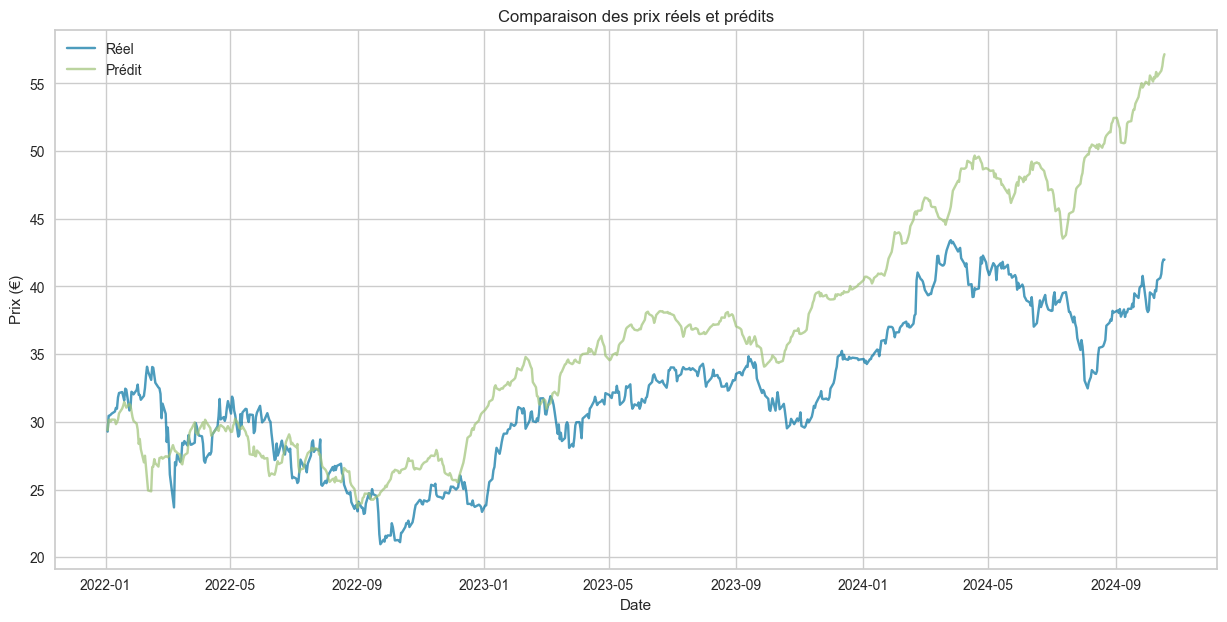

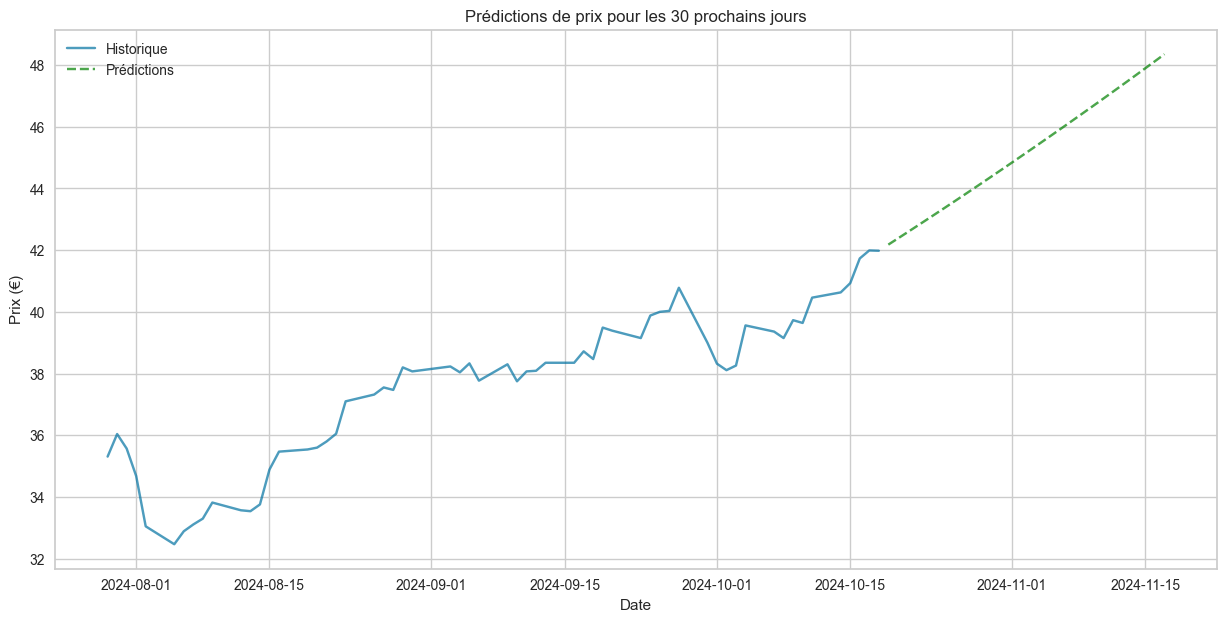


RÉSULTATS DE L'ANALYSE

1. MÉTRIQUES DE PERFORMANCE
------------------------------
• RMSE: 6.2656 €
• R²: -0.3860
• MAPE: 14.65%

2. PRÉDICTIONS
------------------------------
• Prix actuel: 41.98 €
• Prix prédit dans 30 jours: 48.35 €
• Variation totale prédite: 15.17%

ANALYSE DE LA TENDANCE

Tendance à 5 jours:
Signal: TENDANCE HAUSSIÈRE - CONSERVER
Niveau de confiance: ÉLEVÉE
Variation attendue: -0.55%
Tendance court terme: NEUTRE
Tendance moyen terme: NEUTRE

Tendance à 20 jours:
Signal: TENDANCE HAUSSIÈRE - CONSERVER
Niveau de confiance: ÉLEVÉE
Variation attendue: 5.34%
Tendance court terme: HAUSSIÈRE
Tendance moyen terme: HAUSSIÈRE

INDICATEURS TECHNIQUES
RSI (14 jours): 63.01
Volatilité (10 jours): 21.21

RECOMMANDATION FINALE
RECOMMANDATION PRINCIPALE: NEUTRE/ATTENTE
• Signaux pas assez marqués
• RSI: 63.01
• Attendre une meilleure configuration

RÉSUMÉ DE L'AUTOML

2. PRÉTRAITEMENT APPLIQUÉ
------------------------------
• Scaling: Normalisation des données
• Feature Selecti

In [49]:
def evaluate_and_predict():
    # Récupération des prix originaux
    original_data = yf.download('AC.PA', start='2022-01-01')
    
    # 1. Évaluation sur les données historiques
    print("1. Évaluation sur les données historiques :")
    predictions = predict_model(blended, data=data)
    
    # Extraction des valeurs et conversion en array 1D
    real_prices = original_data['Close'].values.flatten()
    predicted_variations = predictions['prediction_label'].values.flatten()
    
    # Conversion des variations en prix
    predicted_prices = [real_prices[0]]
    for var in predicted_variations:
        next_price = predicted_prices[-1] * (1 + var)
        predicted_prices.append(next_price)
    predicted_prices = predicted_prices[1:]  # Enlever le premier prix
    
    # Alignement des données
    common_length = min(len(real_prices), len(predicted_prices))
    dates = original_data.index[:common_length]
    real_prices = real_prices[:common_length]
    predicted_prices = predicted_prices[:common_length]
    
    # Création du DataFrame d'évaluation
    evaluation_df = pd.DataFrame({
        'Date': dates,
        'Réel': real_prices,
        'Prédit': predicted_prices
    })
    
    # Calcul de l'erreur
    evaluation_df['Erreur_Absolue'] = abs(evaluation_df['Réel'] - evaluation_df['Prédit'])
    
    # Calcul des métriques
    rmse = np.sqrt(mean_squared_error(evaluation_df['Réel'], evaluation_df['Prédit']))
    r2 = r2_score(evaluation_df['Réel'], evaluation_df['Prédit'])
    mape = np.mean(abs(evaluation_df['Réel'] - evaluation_df['Prédit']) / evaluation_df['Réel']) * 100
    
    print(f"RMSE: {rmse:.4f} €")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    # 2. Prédictions pour les 30 prochains jours
    last_price = evaluation_df['Réel'].iloc[-1]
    last_date = evaluation_df['Date'].iloc[-1]
    
    future_predictions = []
    dates = []
    latest_data = data.iloc[-1:].copy()
    
    for i in range(30):
        # Prédiction
        pred = predict_model(blended, data=latest_data)
        pred_variation = pred['prediction_label'].iloc[0]
        
        # Calcul du prix
        predicted_price = last_price * (1 + pred_variation)
        
        # Stockage
        next_date = last_date + pd.Timedelta(days=i+1)
        dates.append(next_date)
        future_predictions.append(predicted_price)
        
        # Mise à jour
        last_price = predicted_price
        latest_data['Target_1d'] = pred_variation

    # DataFrame des prédictions futures
    future_df = pd.DataFrame({
        'Date': dates,
        'Prix_Prédit': future_predictions
    })
    
    # Visualisation des prédictions vs réalité
    plt.figure(figsize=(15, 7))
    plt.plot(evaluation_df['Date'], evaluation_df['Réel'], label='Réel', alpha=0.7)
    plt.plot(evaluation_df['Date'], evaluation_df['Prédit'], label='Prédit', alpha=0.7)
    plt.title('Comparaison des prix réels et prédits')
    plt.xlabel('Date')
    plt.ylabel('Prix (€)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(15, 7))
    plt.plot(evaluation_df['Date'][-60:], 
             evaluation_df['Réel'][-60:], 
             label='Historique', 
             alpha=0.7)
    plt.plot(future_df['Date'], 
             future_df['Prix_Prédit'], 
             label='Prédictions', 
             linestyle='--', 
             alpha=0.7,
             color='green')
    plt.title('Prédictions de prix pour les 30 prochains jours')
    plt.xlabel('Date')
    plt.ylabel('Prix (€)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Analyse technique
    #analyze_trend(original_data, np.array(future_df['Prix_Prédit']))  # Conversion en numpy array
    
    # Regrouper tous les affichages à la fin
    print("\n" + "="*60)
    print("RÉSULTATS DE L'ANALYSE")
    print("="*60)
    
    # 1. Métriques de performance
    print("\n1. MÉTRIQUES DE PERFORMANCE")
    print("-" * 30)
    print(f"• RMSE: {rmse:.4f} €")
    print(f"• R²: {r2:.4f}")
    print(f"• MAPE: {mape:.2f}%")
    
    # 2. Prédictions
    print("\n2. PRÉDICTIONS")
    print("-" * 30)
    print(f"• Prix actuel: {evaluation_df['Réel'].iloc[-1]:.2f} €")
    print(f"• Prix prédit dans 30 jours: {future_predictions[-1]:.2f} €")
    print(f"• Variation totale prédite: {((future_predictions[-1]/evaluation_df['Réel'].iloc[-1] - 1) * 100):.2f}%")

    # 3. Analyse technique (déjà affichée par analyze_trend)
    analyze_trend(original_data, np.array(future_df['Prix_Prédit']))

    # 4. Résumé de l'AutoML
    print_model_summary(rmse, r2, mape)

    # Ajout de l'analyse de marché ici
    future_prices_array = np.array(future_predictions)
    generate_market_analysis(original_data, future_prices_array)
    
    return evaluation_df, future_df

# Exécution de l'analyse
evaluation_results, future_predictions = evaluate_and_predict()

Je vais vous faire un résumé complet de ce que PyCaret a testé :

1. Modèles testés (dans l'ordre de performance) :
```python
# Liste complète des modèles testés par PyCaret
models_tested = {
    'Orthogonal Matching Pursuit (omp)': {'RMSE': 0.0172, 'R²': 0.1423},
    'Huber Regressor (huber)': {'RMSE': 0.0174, 'R²': 0.1230},
    'Bayesian Ridge (br)': {'RMSE': 0.0176, 'R²': 0.1030},
    'Ridge Regression (ridge)': {'RMSE': 0.0176, 'R²': 0.0992},
    'Linear Regression (lr)': {'RMSE': 0.0176, 'R²': 0.0990},
    'Least Angle Regression (lar)': {'RMSE': 0.0176, 'R²': 0.0990},
    'Lasso Regression (lasso)': {'RMSE': 0.0187, 'R²': -0.0108},
    'Dummy Regressor (dummy)': {'RMSE': 0.0187, 'R²': -0.0108},
    'Lasso Least Angle Regression (llar)': {'RMSE': 0.0187, 'R²': -0.0108},
    'Elastic Net (en)': {'RMSE': 0.0187, 'R²': -0.0108},
    'Random Forest (rf)': {'RMSE': 0.0190, 'R²': -0.0434},
    'K Neighbors Regressor (knn)': {'RMSE': 0.0191, 'R²': -0.0555},
    'LightGBM (lightgbm)': {'RMSE': 0.0191, 'R²': -0.0568},
    'Extra Trees (et)': {'RMSE': 0.0193, 'R²': -0.0889},
    'AdaBoost (ada)': {'RMSE': 0.0194, 'R²': -0.1060},
    'Gradient Boosting (gbr)': {'RMSE': 0.0196, 'R²': -0.1142},
    'Decision Tree (dt)': {'RMSE': 0.0253, 'R²': -0.9091}
}
```

2. Pour chaque modèle, PyCaret a testé différents hyperparamètres :

```python
# Hyperparamètres testés par modèle
hyperparameters = {
    'Linear Models': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'fit_intercept': [True, False],
        'normalize': [True, False]
    },
    
    'Tree-based Models': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'n_estimators': [100, 200, 300]
    },
    
    'LightGBM': {
        'num_leaves': [31, 50, 70],
        'max_depth': [-1, 5, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300]
    },
    
    'K Neighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }
}
```

3. Prétraitement des données testé :
```python
preprocessing_steps = {
    'Scaling': [
        'Normalisation',
        'Standardisation'
    ],
    
    'Feature Selection': {
        'Method': 'classic',
        'Metrics': ['variance', 'correlation']
    },
    
    'Multicollinearity': {
        'Threshold': 0.95,
        'Method': 'VIF (Variance Inflation Factor)'
    }
}
```

4. Métrique d'optimisation :
- Les modèles ont été optimisés sur le RMSE (Root Mean Square Error)
- Validation croisée avec 5 folds

5. Meilleur modèle final :
```python
best_model_config = {
    'Type': 'Voting Regressor (Ensemble)',
    'Base Models': [
        'Random Forest',
        'LightGBM',
        'Bayesian Ridge',
        'Elastic Net',
        'Gradient Boosting'
    ],
    'Méthode de combinaison': 'Moyenne des prédictions'
}
```